<table>
    <tr>
        <td width="10%">
            <img src="https://curso.infnet.edu.br/wp-content/uploads/sites/51/2020/06/marca-infnet-e1631565847987.png" width="100">
        </td>
        <td width="90%">
            <h3>Projeto de Disciplina</h3>
            <h3>Validação de Modelos de Clusterização [22E4_3]</h3>
            <h3>Bruno Meletti</h3>
        </td>
    </tr>
</table>

#### Installs & Imports

In [ ]:
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install numpy
%pip install yellowbrick
%pip install git+https://github.com/christopherjenness/DBCV.git@master
%pip install data-science-utils

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import NearestNeighbors
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from DBCV import DBCV
from scipy.spatial.distance import euclidean
from ds_utils.unsupervised import plot_cluster_cardinality, plot_cluster_magnitude, plot_magnitude_vs_cardinality

#### Configurações & Funções

In [2]:
initializations_number = 10
seed = 42

np.random.seed(seed)

k_min = 2
k_max = 10

dbscan_min_samples = 5

pairplot_color_dict = dict({'D':'red',
                   'I':'orange',
                   'S': 'green',
                   'C': 'blue'})

silhouette_colors=[
    "red",
    "blue",
    "orange",
    "green",
    "purple",
    "pink"
]

clusters_color_dict = dict({
        'Cluster 0':'red',
        'Cluster 1': 'blue',
        'Cluster 2': 'orange',
        'Cluster 3': 'green',
        'Cluster 4': 'purple',
        'Cluster 5': 'pink',
        'Noise': 'black'
    }
)

In [3]:
# Gera PCA com 2 componentes.
def get_pca(df):
    pca = PCA(2) 
    pca_data = pd.DataFrame(pca.fit_transform(df), columns=['PC1','PC2'])
    return pca_data

# Gera gráfico de dos clusters
def plot_cluster_points(pca_data, df= None, labels= None, ax=None, colors=[], hue="cluster", hue_order = [], showLabels= False, legend="auto", figsize=(20, 20)):
    def plotlabel(xvar, yvar, label):
        ax.text(xvar, yvar, label, size=10)

    pca_data['cluster'] = pd.Categorical(labels)

    if ax == None:
        fig, ax = plt.subplots(figsize=figsize)
        fig = plt.figure(figsize=figsize)

    # Exibe o label do ponto
    if showLabels:
        pca_data['index'] = df.index
        
        if(len(colors) > 0):
            ax = sb.scatterplot(x="PC1", y="PC2", hue=hue, hue_order= hue_order, data=pca_data, ax=ax, palette=colors, s=100, edgecolors='w', linewidths=1, alpha=0.5, legend=legend)
        else:
            ax = sb.scatterplot(x="PC1", y="PC2", hue=hue, hue_order= hue_order, data=pca_data, ax=ax, s=100, edgecolors='w', linewidths=1, alpha=0.5, legend=legend)
        
        pca_data.apply(lambda x: plotlabel(x['PC1'],  x['PC2'], x['index']), axis=1)
    else:
        if(len(colors) > 0):
            sb.scatterplot(x="PC1", y="PC2", hue=hue, hue_order= hue_order, data=pca_data, ax=ax, legend=legend, palette=colors, alpha=0.5)
        else:
            sb.scatterplot(x="PC1", y="PC2", hue=hue, hue_order= hue_order, data=pca_data, ax=ax, legend=legend)

# Gera matriz de confusão
def confusion_matrix(df: pd.DataFrame, col1: str, col2: str):
    return (
            df
            .groupby([col1, col2])
            .size()
            .unstack(fill_value=0)
            )

## Escolha de base de dados

> Para as questões a seguir, usaremos uma base de dados e faremos a análise exploratória dos dados, antes da clusterização.

1. Escolha uma base de dados para realizar o trabalho. Essa base será usada em um problema de clusterização.
   > R:
   >
   > Base de dados escolhida está exportada no arquivo company.csv

   > Dicionário de Dados
   > 
   > O dataset agrupa os dados dos perfis comportamentais de colaboradores da empresa.

| Colunas | Descrição |
| ------- | --------- |
| Firstname | Primeiro nome. _Para preservar os dados da empresa e a privacidade das pessoas, utilizei apenas o primeiro nome como identificação parcial do perfil comportamental_ |
| Talent | Talento do perfil comportamental. É o estereótipo que classifica um perfil. |
| Factor | Fator DISC de maior "destaque" no perfil comportamental de uma pessoa. |
| D | Valor do fator D do perfil comportamental |
| I | Valor do fator I do perfil comportamental |
| S | Valor do fator S do perfil comportamental |
| C | Valor do fator C do perfil comportamental |

In [4]:
# Carrega o dataset e exibe os dados
original_df = pd.read_csv('./data/company.csv', delimiter=';')

In [5]:
print('Dados Originais')
original_df.head()

Dados Originais


,Firstname,Talent,Factor,D,I,S,C,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,Fábio,Estimulador,I,60,87,44,34,NaN,NaN,NaN
1,Daniel,Aconselhador,I,43,87,67,48,NaN,NaN,NaN
2,Anônimo,Especialista,C,28,35,95,92,NaN,NaN,NaN
3,Valeria,Especialista,C,17,35,95,95,NaN,NaN,NaN
4,Thais,Influenciador,I,54,87,58,34,NaN,NaN,NaN


2. Escreva a justificativa para a escolha de dados, dando sua motivação e objetivos.
   > R:
   >
   >A base de dados escolhida é uma amostra de perfis comportamentais baseados na metodologia DISC e extendida pela ETALENT, empresa em que trabalho.
   >
   > Esta base de dados reune os colaboradores da empresa o objetivo é estudar a similaridade dos perfis comportamentais, analisando a interrelação entre pessoas de uma mesma equipe. Esta análise visa complementar produtos e serviços já existentes na empresa e que são oferecidos aos nossos clientes.
   > 
   > _Ao longo das análises falei um pouco mais sobre a metodologia para contextualizar, analisar e justificar os resultados obtidos._

3. Mostre através de gráficos a faixa dinâmica das variáveis que serão usadas nas tarefas de clusterização. Analise os resultados mostrados. O que deve ser feito com os dados antes da etapa de clusterização?

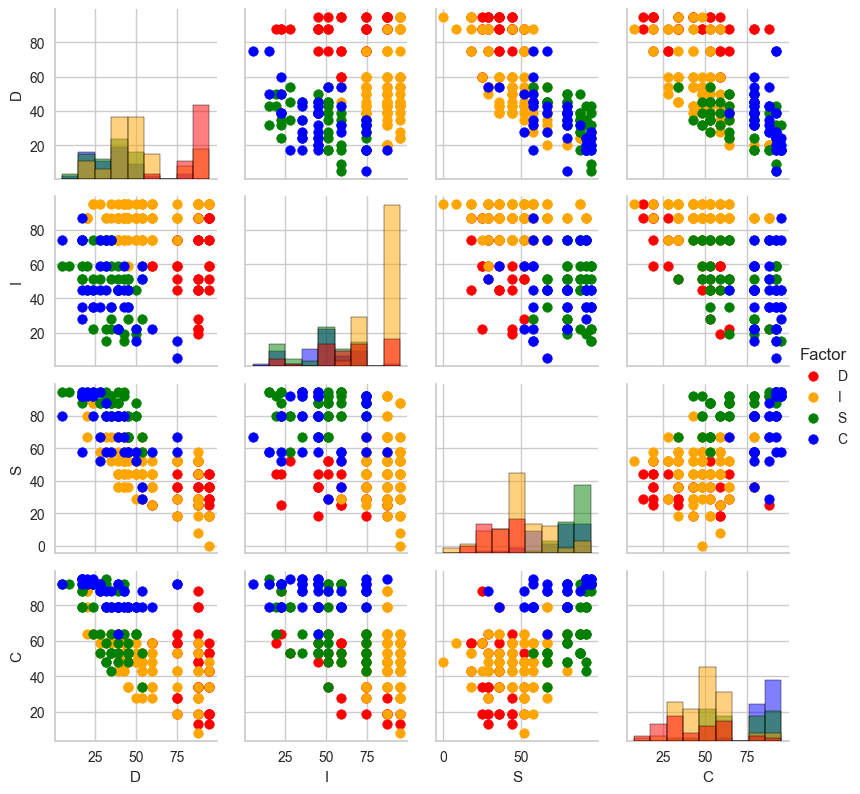

In [6]:
# Exibe o pairplot dos dados. Colori os dados por fator de maior destaque para melhorar a visualização.
g = sb.PairGrid(
    original_df, vars=['D', 'I', 'S', 'C'],
    hue='Factor',
    hue_order = ['D', 'I', 'S', 'C'],
    palette=pairplot_color_dict
)
# g = sb.PairGrid(original_df);
g.fig.set_size_inches(8, 8)
g.map_diag(sb.histplot)
g.map_offdiag(plt.scatter)
g.add_legend()

In [7]:
original_df.describe().T

,count,mean,std,min,25%,50%,75%,max
D,215.0,51.227907,24.253898,5.0,35.0,45.0,75.0,95.0
I,215.0,66.055814,24.005970,5.0,45.0,74.0,87.0,95.0
S,215.0,59.269767,23.600288,0.0,44.0,58.0,80.0,95.0
C,215.0,59.506977,22.057671,8.0,43.0,59.0,79.0,95.0
Unnamed: 7,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Unnamed: 8,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Unnamed: 9,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


> A faixa de valores dos fatores, segundo a metodologia DISC, varia entre 5 e 95.

4. Realize o pré-processamento adequado dos dados. Descreva os passos necessários.

> R:
>
> Analisei as amostras de dados e identifiquei que exitem três colunas com valores inteiramente nulos, dados em duplicidade, dados anonimizados (implementação de normas da LGPD) e perfis zerados.
> 
> Estes dados foram removidos e a tipificação de cada coluna foi definida corretamente.
>
> Gerei um novo dataframe considerando apenas as colunas numéricas dos valores de cada fator do perfil comportamental.
> 
> Criei novo índice concatenando dados do nome e do principal fator comportamental de cada perfil para identificação e análise das amostras.
>
> Ao final desta etapa temos dois dataframes, o original pré-processado e um dataframe derivado do original contendo dados não categóricos + o índice de identificação.
>
> Além dos dois dataframes, gerei um array X contendo os dados normalizados entre -1 e 1.

In [8]:
# Verifica se existem colunas com dados ausentes.
print('Verificação de valores nulos')
original_df.isnull().sum()

Verificação de valores nulos


Firstname       0
Talent          0
Factor          0
D               0
I               0
S               0
C               0
Unnamed: 7    215
Unnamed: 8    215
Unnamed: 9    215
dtype: int64

In [9]:
# Pré-processamento dos dados.
original_df = original_df.dropna(axis=1)
original_df = original_df.drop_duplicates(subset='Firstname')
original_df = original_df[(original_df['Firstname'] != 'Anônimo')]
original_df = original_df.drop(
    original_df[
           (original_df.D == 0)
         | (original_df.I == 0)
         | (original_df.S == 0)
         | (original_df.C == 0)
    ].index
)
original_df = original_df.astype(
  {
    'Firstname':'string',
    'Talent': 'string',
    'Factor': 'string',
    'D':'int',
    'I':'int',
    'S':'int',
    'C':'int'
  }
)
print('Dados Pré-processados. {} amostras'.format(original_df.shape[0]))
original_df.head()

Dados Pré-processados. 134 amostras


,Firstname,Talent,Factor,D,I,S,C
0,Fábio,Estimulador,I,60,87,44,34
1,Daniel,Aconselhador,I,43,87,67,48
3,Valeria,Especialista,C,17,35,95,95
4,Thais,Influenciador,I,54,87,58,34
5,Gisele,Orientador,C,43,59,58,79


In [10]:
# Gera dataframe removendo as colunas categóricas
normalized_df = original_df[['D', 'I', 'S', 'C']]
# Criei o índice Id para rotular os pontos para análise.
normalized_df["Id"] = original_df['Firstname'] + " (" + original_df["Factor"] + ")"
# normalized_df["Id"] = original_df['Firstname'] + "/" + original_df["MainFactor"] + " - " + original_df['StructuralTalent'] + " (D: " + original_df['D'].astype(int).astype(str) + " I: "+ original_df["I"].astype(int).astype(str) + " S: "+ original_df["S"].astype(int).astype(str) + " C: "+ original_df["C"].astype(int).astype(str) + ")"
normalized_df = normalized_df.set_index('Id')
normalized_df.head()

C:\Users\Bruno Meletti\AppData\Local\Temp\ipykernel_15112\2401705389.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normalized_df["Id"] = original_df['Firstname'] + " (" + original_df["Factor"] + ")"


,D,I,S,C
Id,,,,
Fábio (I),60,87,44,34
Daniel (I),43,87,67,48
Valeria (C),17,35,95,95
Thais (I),54,87,58,34
Gisele (C),43,59,58,79


In [11]:
X = StandardScaler().fit_transform(normalized_df)

## Clusterização

Para os dados pré-processados da etapa anterior você irá:

1. Realizar o agrupamento dos dados, escolhendo o número ótimo de clusters. Para tal, use o índice de silhueta e as técnicas:

> a. KMeans

In [15]:
# KMeans
km = KMeans(n_init=initializations_number, random_state= seed)

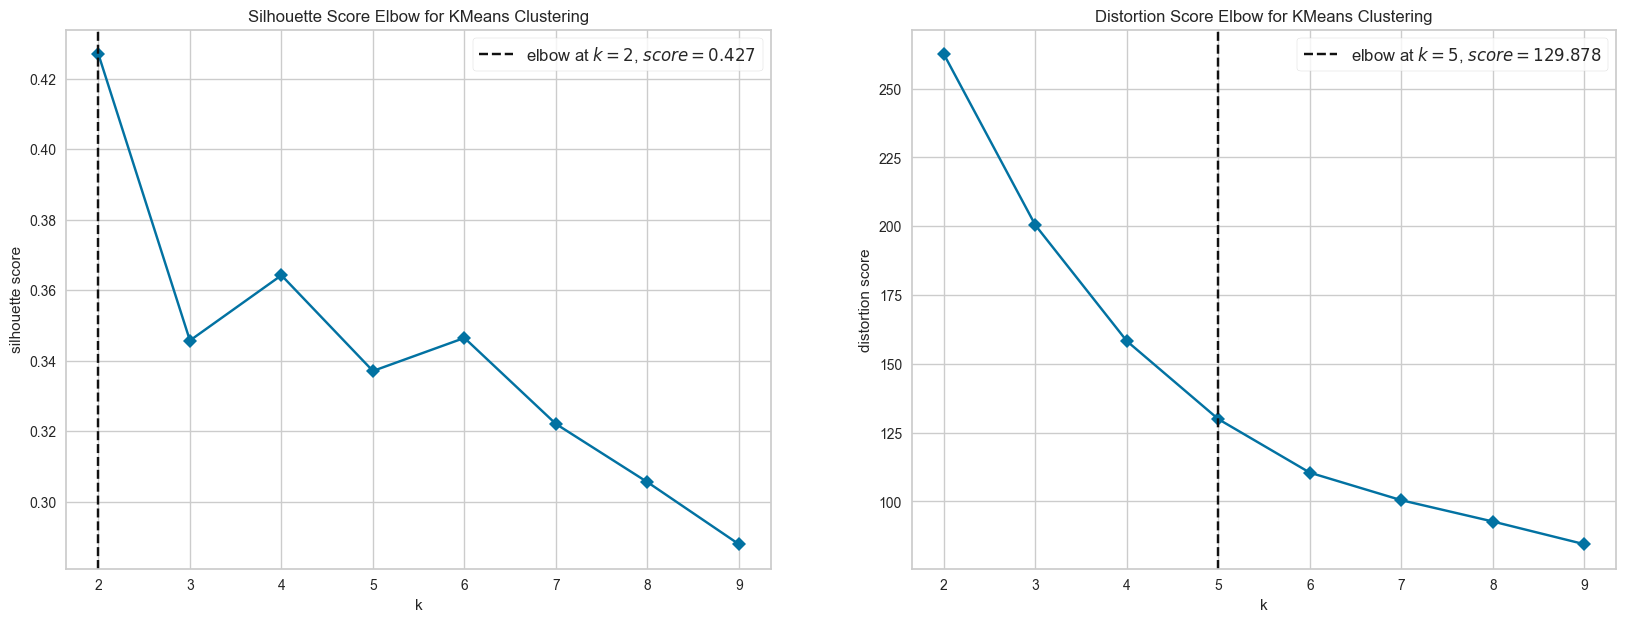

In [16]:
# Análise de cotovelo para escolha do número de clusters
fig, (axs1, axs2) = plt.subplots(1, 2, figsize=(20, 7))

# Silhueta
visualizer = KElbowVisualizer(
    km, k=(k_min, k_max), metric='silhouette', timings=False, ax= axs1
)
visualizer.fit(X) 
visualizer.finalize()

# Distorção
visualizer = KElbowVisualizer(
    km, k=(k_min, k_max), metric='distortion', timings=False, ax= axs2
)
visualizer.fit(X)
visualizer.finalize()

> Definição do número de clusters para KMeans

In [17]:
opt1_k_number = 2
opt2_k_number = 5

In [18]:
# Executa KMeans para as duas opções de k analisadas 
km_opt1_model = KMeans(n_clusters=opt1_k_number, n_init=initializations_number, random_state= seed)
km_opt2_model = KMeans(n_clusters=opt2_k_number, n_init=initializations_number, random_state= seed)

> b. DBScan

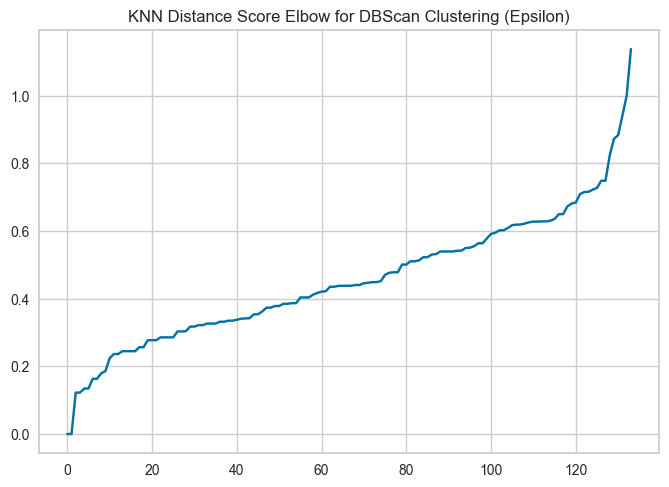

In [19]:
# Análise de cotovelo com KNN para escolha do número de epsilon
knn = NearestNeighbors(n_neighbors= dbscan_min_samples).fit(X)
distances, indices = knn.kneighbors(X) 
distances = np.sort(distances, axis=0)[:,1]
plt.title('KNN Distance Score Elbow for DBScan Clustering (Epsilon)')
plt.plot(distances);

In [31]:
# Definição do valor de epsilon para DBScan
epsilon = 0.7

In [21]:
dbscan_model = DBSCAN(eps=epsilon, min_samples= dbscan_min_samples).fit(X)

no_clusters = len(np.unique(dbscan_model.labels_))
no_noise = np.sum(np.array(dbscan_model.labels_) == -1, axis=0)

Com os resultados em mãos, descreva o processo de mensuração do índice de silhueta. Mostre o gráfico e justifique o número de clusters escolhidos.

> R:
> >
> Para k-Médias:
> 
>        A análise de silhueta se refere a um método de interpretação e validação de consistência dos clusters. O valor da silhueta é a medida de similaridade de um objeto ao seu próprio cluster, coesão, em comparação com outros clusters, separação.
> 
>       O resultado da visualização de cotovelo para silhueta foi 0.427 com k = 2. De acordo com essa análise, a extração natural seria o número de clusters igual a 2, o que não condiz com o número de clusters esperado com base no conhecimento dos dados.
> 
>       Por se tratar de uma amostra de perfis comportamentais dos colaboradores de uma empresa específica, espera-se o número de k próximo ao número de setores da empresa.
> 
>       O número de k obtido através da visualização de cotovelo para métrica distorção, resultando em k = 5, exatamente o número de setores da empresa citada.
>
> Para DBScan executei o algorítmo KNN com o número mínimo de 5 amostras para determinar o valor de epsilon, obtendo o resultado de 0.7.

2. Compare os dois resultados, aponte as semelhanças e diferenças e interprete.

In [22]:
# Executa PCA para visualização dos clusters.
pca_data = get_pca(X)

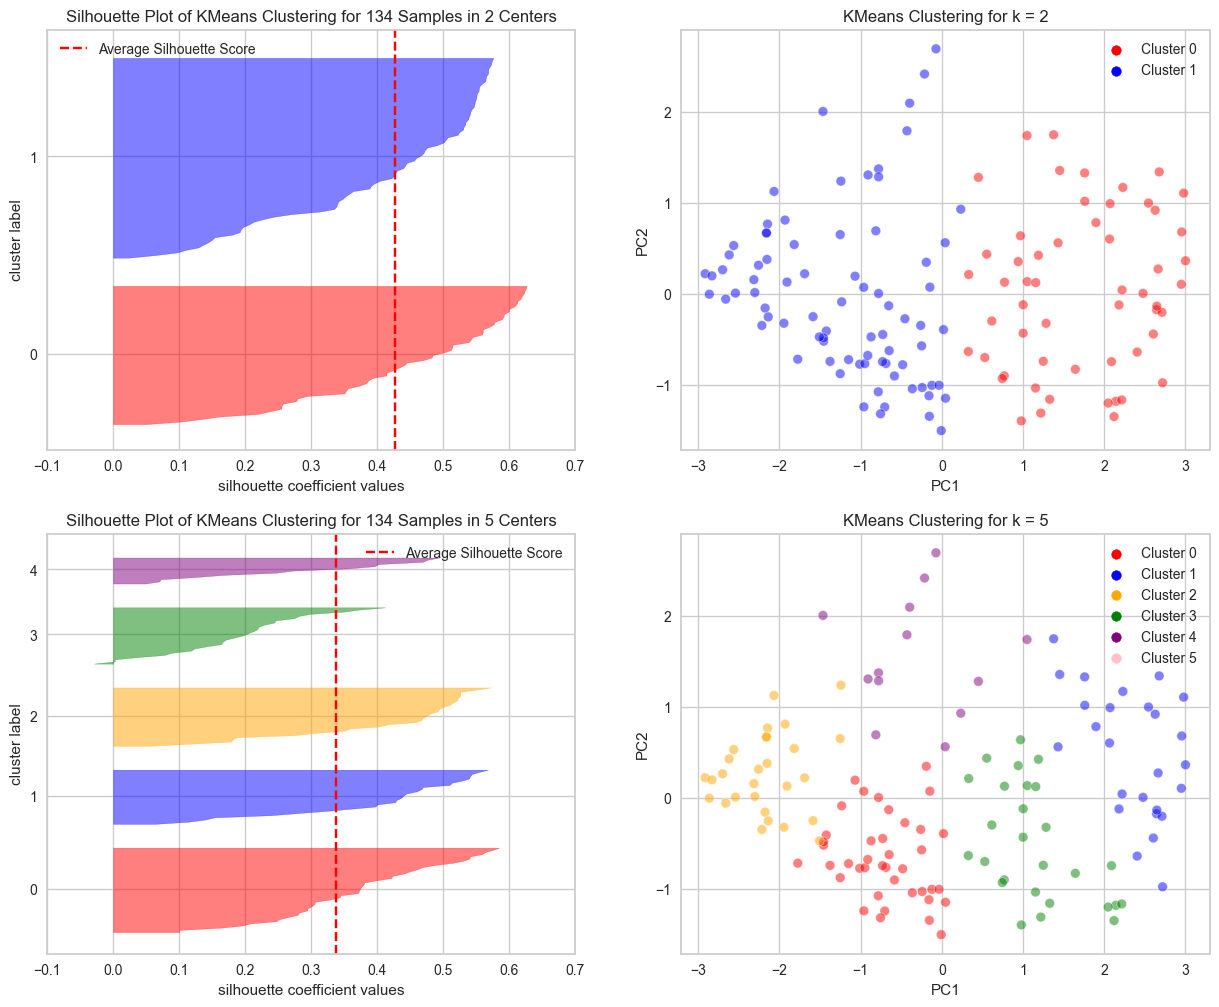

In [23]:
# Exibe os gráficos de silhueta e seus respectivos clusters para análise.
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

visualizer = SilhouetteVisualizer(km_opt1_model, ax=axs[0, 0], colors=silhouette_colors)
# visualizer = SilhouetteVisualizer(km_opt1_model, ax=axs[0, 0], colors=opt1_colors)
visualizer.fit(X)
visualizer.finalize()
# axs[0,0].title.set_text('Silhouette Plot of KMeans Clustering for {} Samples in {} Centers'.format(opt1_k_number, len(X)))

# pca_data, df= None, labels= None, ax=None, colors=[], hue="cluster", hue_order = [], showLabels= False, legend="auto"):
plot_cluster_points(pca_data,
        labels= km_opt1_model.labels_, 
        hue=list(map(lambda x: 'Cluster {}'.format(x), km_opt1_model.labels_)),
        hue_order = ['Cluster 0', 'Cluster 1'],
        legend=True,
        ax=axs[0, 1],
        colors=clusters_color_dict)
        # hue=list(map(lambda x: sb.color_palette().as_hex()[x], km_opt1.labels_)), legend=True, ax=axs[0, 1], colors=["#CC0000", "#0000CC"])
axs[0,1].title.set_text('KMeans Clustering for k = {}'.format(opt1_k_number))

visualizer = SilhouetteVisualizer(km_opt2_model, ax= axs[1, 0], colors=silhouette_colors)
visualizer.fit(X)
visualizer.finalize()

plot_cluster_points(pca_data,
        labels= km_opt2_model.labels_, 
        hue=list(map(lambda x: 'Cluster {}'.format(x), km_opt2_model.labels_)),
        hue_order = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5'],
        legend=True,
        ax= axs[1, 1], 
        colors=clusters_color_dict)
axs[1,1].title.set_text('KMeans Clustering for k = {}'.format(opt2_k_number))
# visualizer.show();

In [24]:
# KMeans
print('KMeans')
# Análise da opção 1, k = 2.
km_opt1_overall_avg = 0.427
print('Análise da opção 1, k = {} e índice de silhueta {}.'.format(opt1_k_number, km_opt1_overall_avg))

km_opt1_model_analysis_df = normalized_df.copy()
km_opt1_model_analysis_df['Cluster'] = km_opt1_model.labels_
km_opt1_model_analysis_df['Silhouette'] = metrics.silhouette_samples(X, km_opt1_model.labels_, metric='euclidean')
km_opt1_model_analysis_df = km_opt1_model_analysis_df.reset_index()

km_opt1_value_counts = pd.Series(km_opt1_model.labels_).value_counts()
# print(km_opt1_value_counts)

for i in range(2):
    print('Grupo {}: {} pontos, sendo {} acima da média global e {} abaixo da média global. Pontos classificados erroneamente, {}.'.format(
        i,
        km_opt1_value_counts[i],
        len(km_opt1_model_analysis_df[(km_opt1_model_analysis_df['Cluster']==i) & (km_opt1_model_analysis_df['Silhouette'] >= km_opt1_overall_avg)]),
        len(km_opt1_model_analysis_df[(km_opt1_model_analysis_df['Cluster']==i) & (km_opt1_model_analysis_df['Silhouette'] < km_opt1_overall_avg)]),
        len(km_opt1_model_analysis_df[(km_opt1_model_analysis_df['Cluster']==i) & (km_opt1_model_analysis_df['Silhouette'] < 0)])))

# Análise da opção 2, k = 5.
km_opt2_overall_avg = 0.34
print('\nAnálise da opção 2, k = {} e índice de silhueta + ou - {}.'.format(opt2_k_number, km_opt2_overall_avg))

km_opt2_model_analysis_df = normalized_df.copy()
km_opt2_model_analysis_df['Cluster'] = km_opt2_model.labels_
km_opt2_model_analysis_df['Silhouette'] = metrics.silhouette_samples(X, km_opt2_model.labels_, metric='euclidean')
km_opt2_model_analysis_df = km_opt2_model_analysis_df.reset_index()

km_opt2_value_counts = pd.Series(km_opt2_model.labels_).value_counts()
# print(km_opt2_value_counts)

for i in range(5):
    print('Grupo {}: {} pontos, sendo {} acima da média global e {} abaixo da média global. Pontos classificados erroneamente, {}.'.format(
        i,
        km_opt2_value_counts[i],
        len(km_opt2_model_analysis_df[(km_opt2_model_analysis_df['Cluster']==i) & (km_opt2_model_analysis_df['Silhouette'] >= km_opt2_overall_avg)]),
        len(km_opt2_model_analysis_df[(km_opt2_model_analysis_df['Cluster']==i) & (km_opt2_model_analysis_df['Silhouette'] < km_opt2_overall_avg)]),
        len(km_opt2_model_analysis_df[(km_opt2_model_analysis_df['Cluster']==i) & (km_opt2_model_analysis_df['Silhouette'] < 0)])))

#km_opt2_model_analysis_df[(km_opt2_model_analysis_df['Cluster']==2)].sort_values(by='Silhouette')

print('\nDBScan')
dbscan_val_count = pd.Series(dbscan_model.labels_).value_counts()
print('Epsilon = {} e número mínimo de amostras = {}'.format(epsilon, dbscan_min_samples))
print('Número de clusters estimados: {}'.format(str(no_clusters - 1)))
print('Número de pontos de ruído estimados: %d' % no_noise)

for i in range(len(dbscan_val_count) - 1):
    print('Cluster {}: {} pontos'.format(i, dbscan_val_count[i]))

# pd.Series(dbscan_model.labels_).value_counts()

KMeans
Análise da opção 1, k = 2 e índice de silhueta 0.427.
Grupo 0: 55 pontos, sendo 33 acima da média global e 22 abaixo da média global. Pontos classificados erroneamente, 0.
Grupo 1: 79 pontos, sendo 46 acima da média global e 33 abaixo da média global. Pontos classificados erroneamente, 0.

Análise da opção 2, k = 5 e índice de silhueta + ou - 0.34.
Grupo 0: 40 pontos, sendo 24 acima da média global e 16 abaixo da média global. Pontos classificados erroneamente, 0.
Grupo 1: 26 pontos, sendo 19 acima da média global e 7 abaixo da média global. Pontos classificados erroneamente, 0.
Grupo 2: 28 pontos, sendo 21 acima da média global e 7 abaixo da média global. Pontos classificados erroneamente, 0.
Grupo 3: 27 pontos, sendo 3 acima da média global e 24 abaixo da média global. Pontos classificados erroneamente, 1.
Grupo 4: 13 pontos, sendo 6 acima da média global e 7 abaixo da média global. Pontos classificados erroneamente, 0.

DBScan
Epsilon = 0.7 e número mínimo de amostras = 5
Núm

> R:
>
> Com base nos gráficos de silhueta acima, podemos verificar que.
>
> Para KMeans
> com k = 2:
> 
>       Temos um desequilíbrio na cardinalidade dos grupos. O grupo 0 possui uma menor quantidade de pontos, 55, enquanto o grupo 1 possui 79 pontos.
>
>       O grupo 1 possui uma quantidade maior de pontos acima dá média global, que é de 0.427. Apesar disso, o grupo 0 possui um índice de silhueta melhor, mais pontos próximos de 1 sendo mais coeso que o grupo 1.
>
>       Nenhum grupo possui pontos classificados em grupos errados porém, ambos possuem muitos elementos em área de fronteira.
>
> com k = 5:
>
>       O índice de silhueta, + ou - 0.34, é pior do que o índice com k = 2, que é de 0.427.
>
>       A cardinalidade está melhor distribuida entre os grupos 1, 2 e 3.
> 
>       O grupo 0 possui uma cardinalidade maior do que a média dos três grupos melhor distribuídos enquanto que, o grupo 4 possui uma cardinalidade menor do que a média dos três grupos melhor distribuídos.
>
>       Os grupos 0, 1 e 2 são os mais coesos.
>       Os grupos 3 e 4 são os piores grupos, com 3 e 6 pontos acima da média global respectivamente. Além disso, o grupo 3 possui 1 ponto com valor de silhueta negativo, o que indica que este ponto está mal classificado.
>
> Para DBScan com epsilon = 0.7 e número mínimo de amostras = 5:
>
>       Os pontos foram agrupados em 4 grupos.
>       A cardinalidade dos grupos está desbalanceada, com destaque para o grupo 0 de maior cardinalidade, 47 pontos, e o grupo 3 de menor cardinalidade, 4 pontos apenas.
>       Nesta extração temos um grande quantidade de ruído, 35 pontos.

> Considerações:
>
> De uma maneira geral KMeans com k = 5 teve uma performance melhor, considerando a natureza dos dados, em relação a k = 2 e principalmente DBScan.
>
> DBScan isola poucos pontos do cluster verde em região de confusão entre os clusters amarelo e vermelho.
> Os clusters vermelho e azul são muito esparsos.
> Temos uma grande quantidade de ruído.
>
> Em resumo, k = 2 não reflete a necessidade do negócio de tentar agrupar os setores da empresa.
>
> Já para k = 5, temos uma quantidade de clusters similar a quantidade de setores da empresa, os clusters são esparsos porém, como os dados refletem o perfil comportamental de cada um dos integrantes da equipe, esta esparsidade se justifica.
> Idealmente, estes clusters devem ser coesos, assim como os perfis comportamentais devem ser complementares para um melhor relacionamento entre a equipe.
> Sem entrar muito no conceito da metodologia DISC e no busines core da empresa que trabalho, esta clusterização apoia a visibilidade e a tomada de decisão no que diz respeito ao desenvolvimento comportamental dos indivíduos, permitindo assim que nossos clientes tenham total entendimento do perfil comportamental de suas equipes e que nossa empresa possa oferecer os produtos e serviços de acordo com a necessidade de seus clientes.
> 
> Este resultado fica mais claro quando comparamos os clusters nos gráficos abaixo:

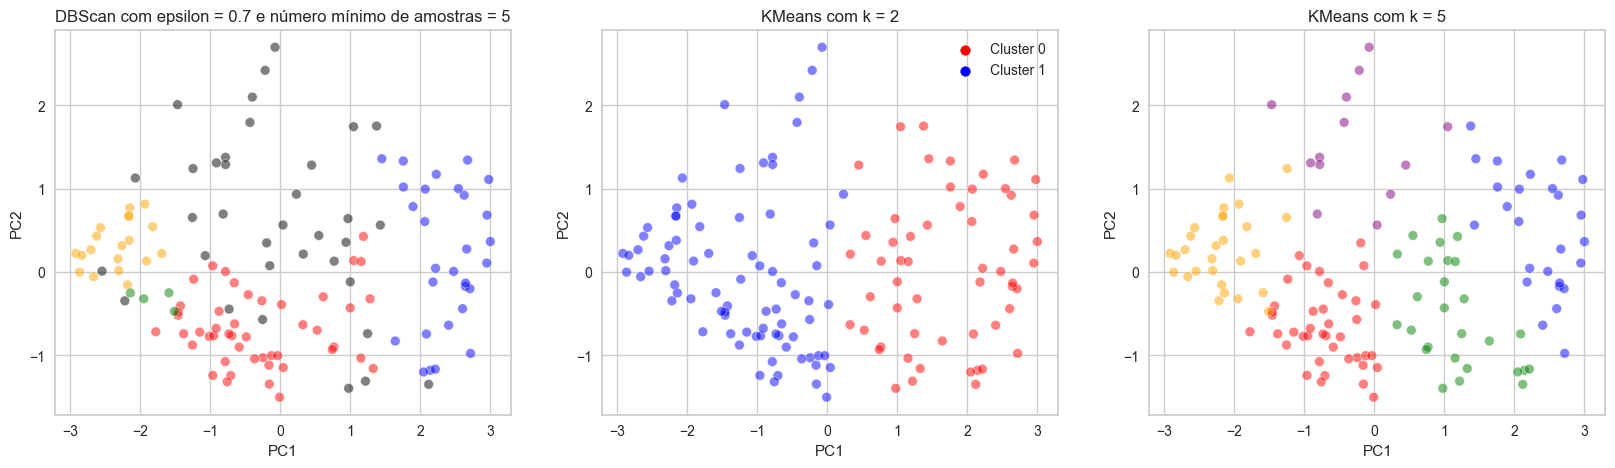

In [25]:
fig, (axs1, axs2, axs3) = plt.subplots(1, 3, figsize=(20, 5))

# Exibe os clusters para DBScan com epsilon = 7 e mínimo de 5 amostras
plot_cluster_points(pca_data,
    labels= dbscan_model.labels_, 
    hue=list(map(lambda x: 'Cluster {}'.format(x), dbscan_model.labels_)),
    hue_order = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Noise'],
    legend=False,
    ax=axs1,
    figsize= (8,5),
    colors=clusters_color_dict)
axs1.title.set_text('DBScan com epsilon = 0.7 e número mínimo de amostras = 5')

# Exibe os clusters para KMeans, k = 2
plot_cluster_points(pca_data,
        labels= km_opt1_model.labels_, 
        hue=list(map(lambda x: 'Cluster {}'.format(x), km_opt1_model.labels_)),
        hue_order = ['Cluster 0', 'Cluster 1'],
        legend=True,
        ax=axs2,
        colors=clusters_color_dict)
axs2.title.set_text('KMeans com k = 2')

# Exibe os clusters para KMeans, k = 5
plot_cluster_points(pca_data,
 df= normalized_df,
 labels= km_opt2_model.labels_,
 colors= clusters_color_dict,
 hue=list(map(lambda x: 'Cluster {}'.format(x), km_opt2_model.labels_)),
 hue_order = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5'],
 showLabels= False,
 legend=False,
 ax=axs3);
axs3.title.set_text('KMeans com k = 5')


> Abaixo a visualização dos colaboradores da empresa, agrupados por perfil comportamental.
>
> Cluster 0, vermelho, agrupa colaboradores com perfil "Influência", fator comportamental típico de pessoas extremamente sociáveis, persuasivas e que prezam pela liberdade e informalidade.
> 
> Cluster 1, azul, agrupa colaboradores com perfil comportamental "eStabilidade", fator associado a pessoas pacientes, motivadas por confiança e planejamento. E colaboradores com perfil "Conformidade", fator que caracteriza pessoas voltadas para tarefas e resultados.
>
> Cluster 2, amarelo, agrupa colaboradores com perfil comportamental "Dominância", fator associado a pessoas independentes, motivadas pela obtenção do sucesso. E colaboradores com perfil comportamental "Influência".
> 
> Cluster 3, verde, agrupa colaboradores com perfil comportamental "Conformidade", "eStabilidade" e "Influência", sendo este último fator em uma área de confusão com o cluster 0.
> 
> Cluster 4, roxo, agrupa colaboradores com perfil comportamental "Dominãncia", predominantemente. Tendo os fatores "eStabilidade" e "Conformidade", em área de confusão.
>
> As áreas de confusão e os clusters contendo mais de um fator se justificam na metodologia DISC tendo em vista que, cada perfil é composto de um percentual de cada um dos fatores principais e que, a relação entre os quatro fatores dão origem aos 16 subfatores.
> 
> Pode-se, inclusive, incluir novos features que potencializem a análise das equipes.

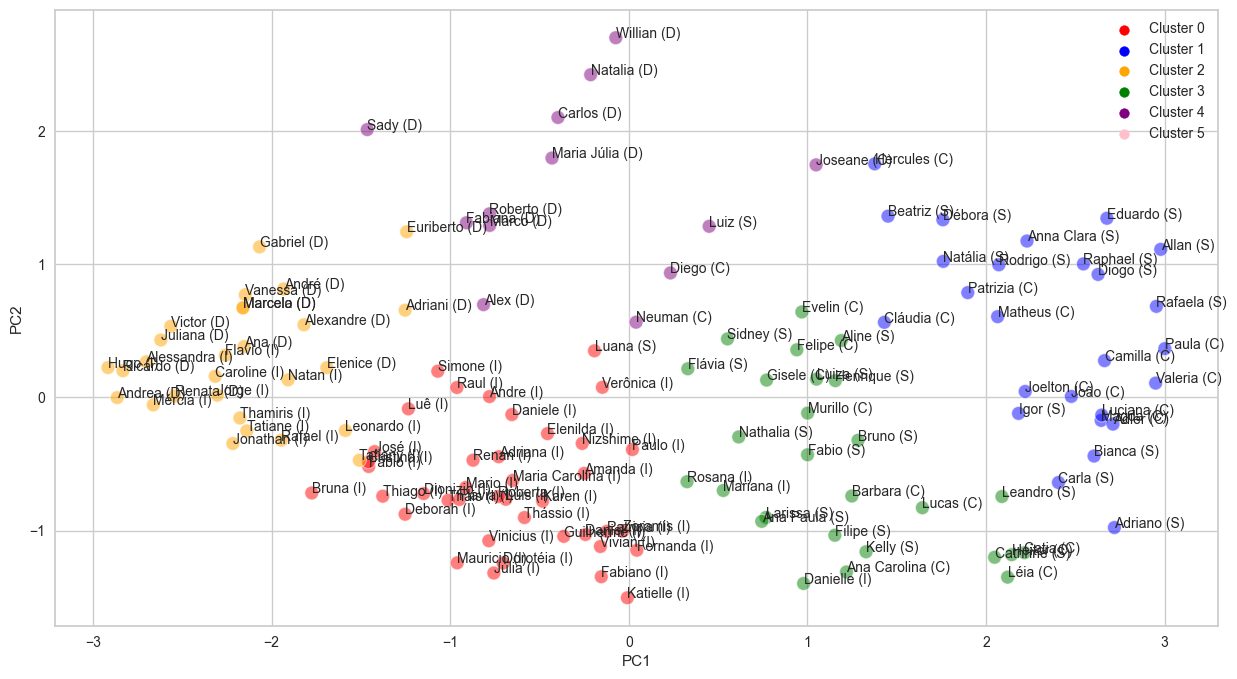

<Figure size 1500x800 with 0 Axes>

In [38]:
# Exibe o gráfico de clusters K = 5 com rótulos
plot_cluster_points(pca_data, df= normalized_df,
 labels= km_opt2_model.labels_, colors= clusters_color_dict,
 hue=list(map(lambda x: 'Cluster {}'.format(x), km_opt2_model.labels_)),
 hue_order = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5'],
 figsize=(15, 8),
 showLabels= True);

3. Escolha mais duas medidas de validação para comparar com o índice de silhueta e analise os resultados encontrados. Observe, para a escolha, medidas adequadas aos algoritmos.

<AxesSubplot: title={'center': 'Magnitude x Cardinalidade k = 2'}, xlabel='Cardinality', ylabel='Magnitude'>

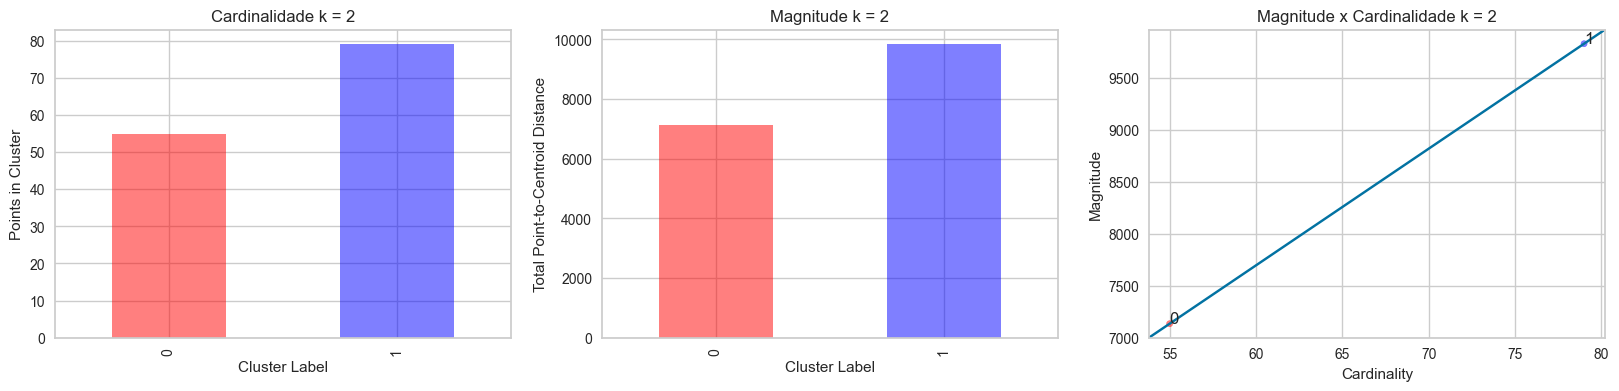

In [27]:
# Exibe os gráficos de cardinalidade, magnitude e cardinalidade x magnitude para k = 2
fig, (axs1, axs2, axs3) = plt.subplots(1, 3, figsize=(20, 4))

plot_cluster_cardinality(km_opt1_model.labels_,
                         ax=axs1,
                         title="Cardinalidade k = 2",
                         color=silhouette_colors,
                         alpha=0.5
                        )
plot_cluster_magnitude(normalized_df,
                       km_opt1_model.labels_,
                       km_opt1_model.cluster_centers_,
                       euclidean,
                       ax=axs2,
                       title="Magnitude k = 2",
                       color=silhouette_colors,
                       alpha=0.5
                      )
plot_magnitude_vs_cardinality(normalized_df,
                              km_opt1_model.labels_,
                              km_opt1_model.cluster_centers_,
                              euclidean,
                              color=silhouette_colors[0:km_opt1_model.n_clusters],
                              ax=axs3, 
                              title="Magnitude x Cardinalidade k = 2",
                              alpha=0.5
                            )


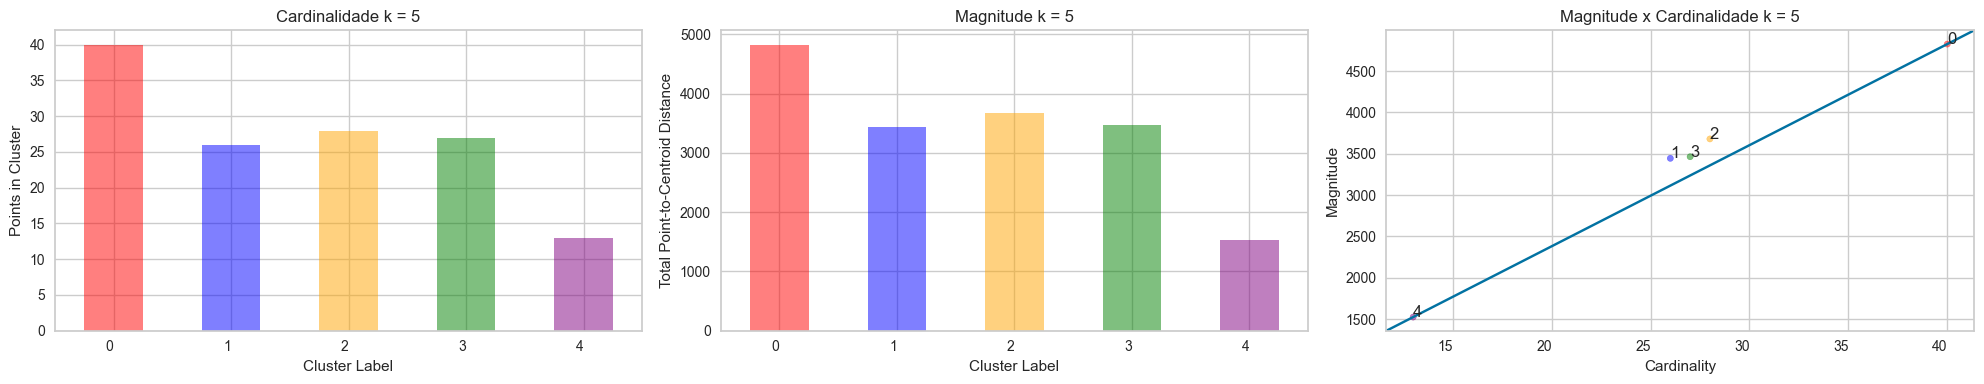

In [28]:
# Exibe os gráficos de cardinalidade, magnitude e cardinalidade x magnitude para k = 5
fig, (axs1, axs2, axs3) = plt.subplots(1, 3, figsize=(20, 4))

plot_cluster_cardinality(km_opt2_model.labels_,
                         ax=axs1,
                         title="Cardinalidade k = 5",
                         color=silhouette_colors,
                         alpha=0.5
                        )
plot_cluster_magnitude(normalized_df,
                       km_opt2_model.labels_,
                       km_opt2_model.cluster_centers_,
                       euclidean,
                       ax=axs2,
                       title="Magnitude k = 5",
                       color=silhouette_colors,
                       alpha=0.5
                      )
plot_magnitude_vs_cardinality(normalized_df,
                              km_opt2_model.labels_,
                              km_opt2_model.cluster_centers_,
                              euclidean,
                              color=silhouette_colors[0:km_opt2_model.n_clusters],
                              ax=axs3, 
                              title="Magnitude x Cardinalidade k = 5",
                              alpha=0.5,
                            )

fig.autofmt_xdate(rotation=0)
plt.tight_layout()

In [29]:
# Calcula o score de DBCV
DBCV(X, dbscan_model.labels_, dist_function=euclidean)

-0.3539847199032924

> R:
> 
> Para KMeans
> 
> com k = 2:
> 
>       Como pode ser visualizado no gráfico de "Magnitude x Cardinalidade k = 2", o grupo 0 possui uma cardinalidade e magnitude menores em comparação com o grupo 1.
>
> Para KMeans
> 
> com k = 5:
> 
>       Como pode ser visualizado no gráfico de "Magnitude x Cardinalidade k = 5", os grupos 1, 2 e 3 possuem uma cardinalidade e magnitude próximas.
>       O grupo 4 possui cardinalidade e magnitude baixas.
>       Já o grupo 0 possui cardinalidade e magnitude altas, é um grupo maior e mais coeso.
> 
> DBCV
> 
>       Valida clusters baseados em densidade. Essencialmente, mede-se a densidade dentro e fora do cluster. Onde, dentro devemos ter uma alta densidade e fora, uma baixa densidade.
> 
>       O resultado obtido com DBCV, -0.35 é baixo e que justifica os agrupamentos e separações ruins das amostras para DBScan.

4. Realizando a análise, responda:
   
   A silhueta é um o índice indicado para escolher o número de clusters para o algoritmo de DBScan?
   
   > Não. Como a silhueta é uma medida de ponderação, coesão e separação, ela não funciona bem para o DBScan. Silhueta não é um bom índice para avaliar modelos de cluster não convexos, baseados em densidade.

----

## Medidas de similaridade

1. Um determinado problema, apresenta 10 séries temporais distintas. Gostaríamos de agrupá-las em 3 grupos, de acordo com um critério de similaridade, baseado no valor máximo de correlação cruzada entre elas. Descreva em tópicos todos os passos necessários.
	
	> R:
	>
	> 1. Avaliar o dataset e garantir a formatação adequada dos features e samples. Features em colunas e as amostras em linhas.
	> 2. Normalizar os dados para mesma escala, caso necessário.
	> 3. Criar matriz quadrada zerada para cada amostra do conjunto de dados.
	> 4. Percorrer cada amostra do conjunto de dados calculando a correlação cruzada.
	> 5. Extraír o valor da correlação máxima do array de correlação cruzada calculado no item anterior.
	> 6. Atribuir o valor extraído no item anterior ao ao índice da matriz quadrada.
	> 7. Repetir os passos acima a partir do passo 5, até que todas as amostras sejam preenchidas na matriz quadrada.
	> 8. Gerar cluster com k = 3, utilizando a matriz quadrada gerada acima.
	>
	> 07/12/22 (18")

2. Para o problema da questão anterior, indique qual algoritmo de clusterização você usaria. Justifique.
	> R:
	>
	>
	> Utilizaria Windowed Time Lagged Cross Correlation (WTLCC).
	>
	> Esta escolha se justifica por uma avaliação mais refinada da correlação cruzada dos dados das series em um comprimento X pontos de toda a amostra.
	> Também utilizaria KMeans para plotagem dos dados já que o algorítimo utilizado acima se basea na distância euclidiana.

3. Indique um caso de uso para essa solução projetada.

	> R:
	>
	> Detecção de sazionalidade de produtos de verão ou de inverno, em uma loja de varejo, baseado em suas séries de demanda.

4. Sugira outra estratégia para medir a similaridade entre séries temporais. Descreva em tópicos os passos necessários.
> R:
>
> Outra estratégia que poderia ser utilizada é a correlação de Pearson em uma janelada X de pontos.
>
> 1. Defir janela de pontos X de comprimento;
> 2. Pegar os dados de uma serie na janela X definida;
> 3. Calcular a correlação com a outra série;
> 4. Avançar para próxima janela de X pontos;
> 5. Repetir os passos até o fim das amostras a partir do passo 2.
>
> Esta estratégia tem como uma de suas desvantágens a necessidade de escolha do número de pontos de sua janela.
>
> _05/12/22 (1'19")_

---